# Read sequences

In [8]:
import re
import numpy as np

def read_fasta(fasta_fp):
    fasta_lines = open(fasta_fp).readlines()
    sequences_dct = dict()
    sequences_array = []
    if re.search(">",fasta_lines[0]) is None:
        print("This is not a valid fasta format")
    for line in fasta_lines:
        if line.strip():
            if re.search(">", line):
                sp = line.replace(">","").replace("\n","").strip()
            else:
                seq = line.strip("\n")
                sequences_array.append(seq)
                sequences_dct[sp] = seq
    sequences_array = np.array(sequences_array)
    return sequences_dct

In [12]:
peak_file = '../model_training/data/model1_IL4Enhancer/C57Bl6_IL4Enhancers.positive.fa'
fasta_dct = read_fasta(peak_file)
pos_data = []
for k in fasta_dct.keys():
    chrom, start, end = k.split('_')[:3]
    seq = str(fasta_dct[k])
    if len(seq) < 300:
        print(k, len(seq))
        continue
    else:
        seq = seq[len(seq)//2-150:len(seq)//2+150]
    pos_data.append((seq, 1, chrom, start, end, k))
print('Total sequence:', len(pos_data))
pos_data[0]

Total sequence: 21659


('GGGCTTCGCAGGGAGAGGGCTGCCAAGTGCCCCATGGCCCCCAGCCCAGACGGAGGCCCACTCACCCCACTTCAGCCAGGCCTCATTTTCCACCCTGGGTAGAGAGACTGCTGGCACCCTGGTTTCCCACAACCACACGACACCCTGTGTACATCCCACAGCCTGACCGTGAAGCAAGGGGTCATTAGCAGCCACAGAAGGCTGGCGATGGCCCAGGCTCCTCACCCACCAACAGTCTGGCAAAGGGATTCCCTAGCTGGGGAAAGAGAACGAGGAATACCCTCCTGCCTGAACCCAGGG',
 1,
 'chr5',
 '140648065',
 '140648415',
 'chr5_140648065_140648415_C57')

# Convert to one hot encode sequences

In [16]:
import random
from Bio import Seq

def dataset2onehot(dataset, shuffle=True):
    nucleotides = ["A", "T", "C", "G"]
    def seq2onehot(seq):
        onehot_list = []
        for nuc in seq:
            if nuc == "N":
                onehot = [0.25 for _ in range(len(nucleotides))]
                onehot_list.append(onehot)
            else:
                onehot = [0 for _ in range(len(nucleotides))]
                onehot[nucleotides.index(nuc)] = 1
                onehot_list.append(onehot)
        return onehot_list
    
    def rc(seq):
        return str((Seq.Seq(seq)).reverse_complement())
    
    onehot_dataset = []
    for (seq, label, chromID, start, end, ID) in dataset:
        onehot_dataset.append((seq2onehot(seq), label, (chromID, start, end, "+")))
        onehot_dataset.append((seq2onehot(rc(seq)), label, (chromID, start, end, "-")))
    
    if shuffle:
        random.shuffle(onehot_dataset)
    
    x_list, y_list, info_list = [], [], [] 
    for (x, y, info) in onehot_dataset:
        x_list.append(x)
        y_list.append(y)
        info_list.append(info)
    return np.array(x_list), np.array(y_list), info_list

In [17]:
x_vis, y_vis, info_vis = dataset2onehot(pos_data, False)

In [18]:
print(x_vis.shape)
print(y_vis.shape)

(43318, 300, 4)
(43318,)


# Score nucleotide importance with DeepLIFT

In [19]:
import keras
from keras.models import model_from_json

import deeplift
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict
from deeplift.util import get_shuffle_seq_ref_function
from deeplift.dinuc_shuffle import dinuc_shuffle

Using TensorFlow backend.


## Define scoring function

In [20]:
keras_model_weights = "../../new_project/tmp/IL4_modelWeights.h5"
keras_model_json = "../../new_project/tmp/IL4_modelJson_tmp.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

nonlinear_mxts_mode = NonlinearMxtsMode.DeepLIFT_GenomicsDefault
deeplift_method = kc.convert_model_from_saved_files(
            h5_file=keras_model_weights,
            json_file=keras_model_json,
            nonlinear_mxts_mode=nonlinear_mxts_mode)
scoring_func = deeplift_method.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault

For layer 2 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 7 the preceding linear layer is 5 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 12 the preceding linear layer is 10 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 16 the preceding linear layer is 15 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsD

## Specify reference and compute importance

In [21]:
batch_size = 128
background = OrderedDict([('A', 0.25), ('C', 0.25), ('G', 0.25), ('T', 0.25)])
scores = np.array(scoring_func(task_idx=0, input_data_list=[x_vis], batch_size=batch_size, 
                               input_references_list=[np.array([background['A'], 
                                                                background['C'], 
                                                                background['G'], 
                                                                background['T']])[None,None,:]],
                               progress_update=1000))
scores = np.sum(scores, axis=2)

Done 0
Done 16000
Done 32000


## Get nucleotide-level max importance from original and reverse compliment sequences

In [22]:
weights = []
for sample_index in range(len(scores)//2):
    sample_scores = np.array([scores[sample_index*2], scores[sample_index*2+1][::-1]])
    sample_score = np.array([sample_scores[j,i] for i,j in enumerate(np.argmax(np.absolute(sample_scores), axis=0))])
    weights.append(sample_score)
weights = np.array(weights)
weights.shape

(21659, 300)

In [23]:
proc_range = 1
smooth_weights = np.array([[np.mean(np.abs(w[max(0, i-proc_range):min(len(w), i+proc_range+1)]))
                         for i in range(len(w))] for w in weights])
print(smooth_weights.shape)

(21659, 300)


# Visualize importance scores for individual site

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

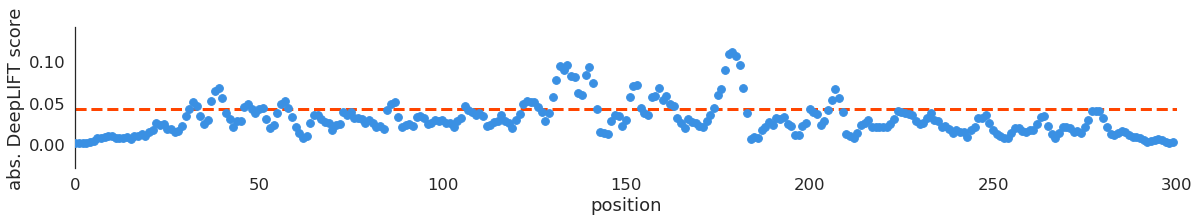

In [37]:
s = 'chr5_140648065_140648415_C57' #sequence ID in FASTA file

sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(17,3.2))
w = np.abs(smooth_weights[np.array(pos_data)[:,-1] == s][0])
plt.scatter(np.arange(len(w)), w, s=60, c='#3A90E3',zorder=10)
plt.axhline(np.sort(w)[240], c='orangered', linestyle='--', linewidth=3)
plt.xlim(0,300)
plt.xlabel('position')
plt.ylabel('abs. DeepLIFT score')
sns.despine(top=True, bottom=True)
plt.tight_layout()